# Baseball Testing

In [1]:
import pandas as pd
import numpy as np
import requests
from rpy2.robjects import r, pandas2ri
import pyreadr
import matplotlib.pyplot as plt
from pandasql import sqldf
from bs4 import BeautifulSoup
from html_table_parser import HTMLTableParser
from selenium import webdriver
import time
from baseball_scraper import playerid_lookup
from unidecode import unidecode
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [2]:
# Setting up function for loading Rdata into python from Github Source

def git_load(Name):
    github_url = f'https://raw.githubusercontent.com/an-izq/Pitcher-HOF-Predictor/main/lahman_1871-2023_csv/lahman_1871-2023_csv/{Name}.csv'
    result = pd.read_csv(github_url, encoding = "ISO-8859-1")
    globals()[f'{Name}_df'] = result
    print(f'{Name}_df Success!')
    
# Setting up function to display the correlation in upper/lower triangle. Inspired by pair.panels in R

def corr_func(x, y, **kwargs):
    corr_value = x.corr(y)
    ax = plt.gca()
    ax.annotate(f'Corr: {corr_value:.2f}', xy=(0.5, 0.5), xycoords=ax.transAxes, ha='center', va='center', fontsize=15)
    
# Setting up function to split lists to equal length

def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

In [3]:
# Calling all Tables from Github
table_names = ['People', 'Pitching', 'AwardsPlayers', 'AwardsSharePlayers', 'PitchingPost', 'Salaries', 'AllstarFull', 'SeriesPost', 'HallOfFame']
table_names

for x in table_names:
    git_load(x)

People_df Success!


Pitching_df Success!
AwardsPlayers_df Success!
AwardsSharePlayers_df Success!
PitchingPost_df Success!
Salaries_df Success!
AllstarFull_df Success!
SeriesPost_df Success!
HallOfFame_df Success!


## People dataframe

In [4]:
# People_df Exploration
People_df = People_df.iloc[:, 1:]
People_df.info()
# print(People_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21010 entries, 0 to 21009
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   playerID      21010 non-null  object 
 1   birthYear     20904 non-null  float64
 2   birthMonth    20735 non-null  float64
 3   birthDay      20593 non-null  float64
 4   birthCity     20867 non-null  object 
 5   birthCountry  20955 non-null  object 
 6   birthState    20464 non-null  object 
 7   deathYear     10266 non-null  float64
 8   deathMonth    10265 non-null  float64
 9   deathDay      10264 non-null  float64
 10  deathCountry  10264 non-null  object 
 11  deathState    10204 non-null  object 
 12  deathCity     10262 non-null  object 
 13  nameFirst     20976 non-null  object 
 14  nameLast      21010 non-null  object 
 15  nameGiven     20973 non-null  object 
 16  weight        20165 non-null  float64
 17  height        20245 non-null  float64
 18  bats          19792 non-nu

In [5]:
People_df.loc[People_df['playerID'] == 'hyndmji01']

playerID  birthYear  birthMonth  birthDay     birthCity birthCountry  \
8895  hyndmji01     1854.0        10.0       1.0  Philadelphia          USA   

     birthState  deathYear  deathMonth  deathDay  ... nameLast   nameGiven  \
8895         PA     1920.0         1.0      14.0  ...  Hyndman  William S.   

     weight height bats throws  debut    bbrefID finalGame   retroID  
8895  150.0   68.0  NaN    NaN    NaN  hyndmji01       NaN  hyndj101  

[1 rows x 24 columns]

## Pitching Dataframe

In [6]:
# Pitching_df Exploration
Pitching_df.info()
#print(Pitching_df.describe())
#Pitching_df['yearID'] = pd.to_datetime(df['yearID'], format = '%Y')
Pitching_df.groupby('ERA')['yearID'].min()
Pitching_df[Pitching_df['ERA'].notnull()]['yearID'].min()
#Pitching_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51368 entries, 0 to 51367
Data columns (total 30 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   playerID  51368 non-null  object 
 1   yearID    51368 non-null  int64  
 2   stint     51368 non-null  int64  
 3   teamID    51368 non-null  object 
 4   lgID      51236 non-null  object 
 5   W         51368 non-null  int64  
 6   L         51368 non-null  int64  
 7   G         51368 non-null  int64  
 8   GS        51368 non-null  int64  
 9   CG        51368 non-null  int64  
 10  SHO       51368 non-null  int64  
 11  SV        51368 non-null  int64  
 12  IPouts    51368 non-null  int64  
 13  H         51368 non-null  int64  
 14  ER        51368 non-null  int64  
 15  HR        51368 non-null  int64  
 16  BB        51368 non-null  int64  
 17  SO        51368 non-null  int64  
 18  BAOpp     46924 non-null  float64
 19  ERA       51271 non-null  float64
 20  IBB       36790 non-null  fl

1871

In [7]:
print(Pitching_df[Pitching_df['IBB'].notnull()]['yearID'].min())
print(Pitching_df[Pitching_df['yearID'] == 1955].iloc[0])
# This gives all players max strikeouts in a year for their career.
# Pitching_df.groupby('playerID')['SO'].max()
# This gives all players mean and count strikeouts in a year for their career count is number of seasons.
# Pitching_df.groupby('playerID')['SO'].agg(['mean', 'count']) # can also provide max, min, and std

1955
playerID    aberal01
yearID          1955
stint              1
teamID           DET
lgID              AL
W                  6
L                  3
G                 39
GS                 1
CG                 0
SHO                0
SV                 3
IPouts           240
H                 86
ER                30
HR                 9
BB                28
SO                37
BAOpp           0.27
ERA             3.38
IBB              1.0
WP                 1
HBP              0.0
BK                 0
BFP            346.0
GF                22
R                 32
SH               NaN
SF               NaN
GIDP             NaN
Name: 89, dtype: object


In [8]:
# joining debut into pitching df and then modifying the debut column
q = '''
SELECT
a.*,
b.debut
FROM
    Pitching_df a
LEFT JOIN
    People_df b
        on a.playerID = b.playerID
;
'''
Pitching_debut_df = sqldf(q, locals())
Pitching_debut_df['debut'] = Pitching_debut_df['debut'].astype(str).str[:4]
Pitching_debut_df.loc[Pitching_debut_df['debut'] == 'None']
Pitching_debut_df.replace('None', None, inplace = True)
Pitching_debut_df['debut'] = Pitching_debut_df['debut'].astype(np.int64)

In [9]:
# keeping all pitchers who have a debut date of greater than 1955
Pitching_1955 = Pitching_debut_df.loc[Pitching_debut_df['debut'] >= 1955]
Pitching_1955 = Pitching_1955.drop(columns=['SH', 'SF', 'GIDP', 'debut'])
len(Pitching_1955)

35499

In [10]:
# Grouping all the players together by sum or avg in my population
q = '''
SELECT
    playerID,
    sum(W) as W_tot,
    sum(L) as L_tot,
    sum(G) as G_tot,
    sum(GS) as GS_tot,
    sum(CG) as CG_tot,
    sum(SHO) as SHO_tot,
    sum(SV) as SV_tot,
    sum(IPouts) as IPouts_tot,
    sum(H) as H_tot,
    sum(ER) as ER_tot,
    sum(HR) as HR_tot,
    sum(BB) as BB_tot,
    sum(SO) as SO_tot,
    avg(BAOpp) as BAOpp_avg,
    avg(ERA) as ERA_avg,
    sum(IBB) as IBB_tot,
    sum(WP) as WP_tot,
    sum(HBP) as HBP_tot,
    sum(BK) as BK_tot,
    sum(BFP) as BFP_tot,
    sum(GF) as GF_tot,
    sum(R) as R_tot
FROM
    Pitching_1955
GROUP BY playerID
;
'''
Pitching_1955_player_career = sqldf(q, locals())
Pitching_1955_player_career

playerID  W_tot  L_tot  G_tot  GS_tot  CG_tot  SHO_tot  SV_tot  \
0     aardsda01     16     18    331       0       0        0      69   
1      aasedo01     66     60    448      91      22        5      82   
2      abadfe01      9     29    406       6       0        0       2   
3     abbotan01      8      6     21      21       0        0       0   
4     abbotco01      1      7     45      10       0        0       0   
...         ...    ...    ...    ...     ...     ...      ...     ...   
6687  zobribe01      0      0      1       0       0        0       0   
6688  zuberty01      1      5     54       0       0        0       0   
6689  zumayjo01     13     12    171       0       0        0       5   
6690  zuniggu01      0      0      2       0       0        0       0   
6691   zychto01      7      3     70       1       0        0       1   

      IPouts_tot  H_tot  ...  SO_tot  BAOpp_avg   ERA_avg  IBB_tot  WP_tot  \
0           1011    296  ...     340   0.257444  5.194444     22.0      12   
1           3328   1085  ...     641   0.250846  3.493077     45.0      22   
2           1064    343  ...     292   0.261083  4.222500     11.0      10   
3            328    100  ...     120   0.244000  3.870000      0.0       1   
4            314    112  ...      97   0.277000  6.213333      0.0       8   
...          ...    ...  ...     ...        ...       ...      ...     ...   
6687           3      0  ...       1   0.000000  0.000000      0.0       0   
6688         148     41  ...      55   0.223500  5.175000      2.0       3   
6689         629    169  ...     210   0.228600  3.442000     11.0      16   
6690           6      2  ...       4   0.250000  4.500000      0.0       0   
6691         218     57  ...      80   0.218333  2.800000      5.0       2   

      HBP_tot  BK_tot  BFP_tot  GF_tot  R_tot  
0        16.0       1   1475.0     141    169  
1         7.0       3   4730.0     235    503  
2        12.0       2   1513.0     103    158  
3         1.0       1    459.0       0     47  
4         9.0       1    481.0      19     74  
...       ...     ...      ...     ...    ...  
6687      0.0       0      5.0       1      0  
6688      2.0       0    222.0      14     31  
6689      4.0       0    911.0      35     80  
6690      0.0       0      8.0       2      1  
6691      8.0       1    309.0      14     24  

[6692 rows x 23 columns]

In [11]:
# looking at info
Pitching_1955_player_career.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6692 entries, 0 to 6691
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   playerID    6692 non-null   object 
 1   W_tot       6692 non-null   int64  
 2   L_tot       6692 non-null   int64  
 3   G_tot       6692 non-null   int64  
 4   GS_tot      6692 non-null   int64  
 5   CG_tot      6692 non-null   int64  
 6   SHO_tot     6692 non-null   int64  
 7   SV_tot      6692 non-null   int64  
 8   IPouts_tot  6692 non-null   int64  
 9   H_tot       6692 non-null   int64  
 10  ER_tot      6692 non-null   int64  
 11  HR_tot      6692 non-null   int64  
 12  BB_tot      6692 non-null   int64  
 13  SO_tot      6692 non-null   int64  
 14  BAOpp_avg   6690 non-null   float64
 15  ERA_avg     6687 non-null   float64
 16  IBB_tot     6691 non-null   float64
 17  WP_tot      6692 non-null   int64  
 18  HBP_tot     6692 non-null   float64
 19  BK_tot      6692 non-null  

In [12]:
# dropping 5 players due to them not having ERA and BAopp due to limited pitching in MLB.
drop_players = Pitching_1955_player_career['playerID'].loc[Pitching_1955_player_career['ERA_avg'].isnull()].tolist()
print(drop_players)
Pitching_1955_player_career = Pitching_1955_player_career[~Pitching_1955_player_career.playerID.isin(drop_players)]
Pitching_1955_player_career.info()

['bruckfr01', 'davalvi01', 'parrage01', 'sundigo01', 'yountla01']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6687 entries, 0 to 6691
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   playerID    6687 non-null   object 
 1   W_tot       6687 non-null   int64  
 2   L_tot       6687 non-null   int64  
 3   G_tot       6687 non-null   int64  
 4   GS_tot      6687 non-null   int64  
 5   CG_tot      6687 non-null   int64  
 6   SHO_tot     6687 non-null   int64  
 7   SV_tot      6687 non-null   int64  
 8   IPouts_tot  6687 non-null   int64  
 9   H_tot       6687 non-null   int64  
 10  ER_tot      6687 non-null   int64  
 11  HR_tot      6687 non-null   int64  
 12  BB_tot      6687 non-null   int64  
 13  SO_tot      6687 non-null   int64  
 14  BAOpp_avg   6686 non-null   float64
 15  ERA_avg     6687 non-null   float64
 16  IBB_tot     6686 non-null   float64
 17  WP_tot      6687 non-null   int64  
 18  HB

In [13]:
# table to be used in analysis and modeling
Pitching_1955_player_career

playerID  W_tot  L_tot  G_tot  GS_tot  CG_tot  SHO_tot  SV_tot  \
0     aardsda01     16     18    331       0       0        0      69   
1      aasedo01     66     60    448      91      22        5      82   
2      abadfe01      9     29    406       6       0        0       2   
3     abbotan01      8      6     21      21       0        0       0   
4     abbotco01      1      7     45      10       0        0       0   
...         ...    ...    ...    ...     ...     ...      ...     ...   
6687  zobribe01      0      0      1       0       0        0       0   
6688  zuberty01      1      5     54       0       0        0       0   
6689  zumayjo01     13     12    171       0       0        0       5   
6690  zuniggu01      0      0      2       0       0        0       0   
6691   zychto01      7      3     70       1       0        0       1   

      IPouts_tot  H_tot  ...  SO_tot  BAOpp_avg   ERA_avg  IBB_tot  WP_tot  \
0           1011    296  ...     340   0.257444  5.194444     22.0      12   
1           3328   1085  ...     641   0.250846  3.493077     45.0      22   
2           1064    343  ...     292   0.261083  4.222500     11.0      10   
3            328    100  ...     120   0.244000  3.870000      0.0       1   
4            314    112  ...      97   0.277000  6.213333      0.0       8   
...          ...    ...  ...     ...        ...       ...      ...     ...   
6687           3      0  ...       1   0.000000  0.000000      0.0       0   
6688         148     41  ...      55   0.223500  5.175000      2.0       3   
6689         629    169  ...     210   0.228600  3.442000     11.0      16   
6690           6      2  ...       4   0.250000  4.500000      0.0       0   
6691         218     57  ...      80   0.218333  2.800000      5.0       2   

      HBP_tot  BK_tot  BFP_tot  GF_tot  R_tot  
0        16.0       1   1475.0     141    169  
1         7.0       3   4730.0     235    503  
2        12.0       2   1513.0     103    158  
3         1.0       1    459.0       0     47  
4         9.0       1    481.0      19     74  
...       ...     ...      ...     ...    ...  
6687      0.0       0      5.0       1      0  
6688      2.0       0    222.0      14     31  
6689      4.0       0    911.0      35     80  
6690      0.0       0      8.0       2      1  
6691      8.0       1    309.0      14     24  

[6687 rows x 23 columns]

## Awards Players Dataframe

In [14]:
# AwardsPlayers_df Exploration
AwardsPlayers_df.info()
print(AwardsPlayers_df.describe())
AwardsPlayers_df.loc[~AwardsPlayers_df["tie"].isna()]
AwardsPlayers_df["awardID"].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6797 entries, 0 to 6796
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   playerID  6797 non-null   object
 1   awardID   6797 non-null   object
 2   yearID    6797 non-null   int64 
 3   lgID      6793 non-null   object
 4   tie       64 non-null     object
 5   notes     5127 non-null   object
dtypes: int64(1), object(5)
memory usage: 318.7+ KB
            yearID
count  6797.000000
mean   1973.840224
std      32.879049
min    1877.000000
25%    1945.000000
50%    1980.000000
75%    2001.000000
max    2023.000000


array(['Lou Gehrig Memorial Award', 'Most Valuable Player', 'NLCS MVP',
       'Outstanding DH Award', 'Pitching Triple Crown', 'Platinum Glove',
       'TSN All-Star', 'TSN Major League Player of the Year',
       'TSN Pitcher of the Year', 'TSN Reliever of the Year',
       'World Series MVP', 'Reliever of the Year Award', 'Silver Slugger',
       'ALCS MVP', 'All-Star Game MVP', 'Roberto Clemente Award',
       'Rookie of the Year', 'Gold Glove', 'Babe Ruth Award',
       'Comeback Player of the Year', 'Cy Young Award',
       'Hank Aaron Award', 'Hutch Award', 'SIlver Slugger',
       'Baseball Magazine All-Star', 'Triple Crown', 'TSN Guide MVP',
       'TSN Player of the Year', 'TSN Fireman of the Year',
       'Branch Rickey Award'], dtype=object)

In [15]:
# Setting up from population of players those who had awards and only keeping those awards that contribute to a players career without being repetitive (limiting amount of awards).
q = '''
SELECT 
a.playerID,
count(*) as award_count
FROM 
    AwardsPlayers_df a
INNER JOIN
    Pitching_1955_player_career b
        on a.playerID = b.playerID
Where awardID in (
                    'Pitching Triple Crown',
                    'Triple Crown',
                    'Most Valuable Player',
                    'Rookie of the Year',
                    'Babe Ruth Award',
                    'World Series MVP',
                    'Cy Young Award',
                    'Gold Glove',
                    'All-Star Game MVP',
                    'Roberto Clemente Award',
                    'Rolaids Relief Man Award',
                    'NLCS MVP',
                    'ALCS MVP',
                    'Silver Slugger',
                    'Hank Aaron Award',
                    'Comeback Player of the Year',
                    'Outstanding DH Award',
                    'Reliever of the Year Award',
                    'SIlver Slugger'
                )
GROUP BY
a.playerID
;
'''

Pitching_1955_awards = sqldf(q, locals())
# table to be used in analysis and modeling
Pitching_1955_awards

playerID  award_count
0    alcansa01            1
1    alfonan01            1
2    andujjo01            1
3    arrieja01            2
4    arroybr01            1
..         ...          ...
289  youngch03            1
290  zachrpa01            1
291  zambrca01            3
292   zitoba01            1
293  zobribe01            1

[294 rows x 2 columns]

## Awards Share Players Dataframe

In [16]:
# AwardsSharePlayers_df Exploration
# AwardsSharePlayers_df.info()
print(AwardsSharePlayers_df.describe())
print(AwardsSharePlayers_df['awardID'].unique())
AwardsSharePlayers_df.loc[AwardsSharePlayers_df['awardID'] == 'Cy Young']

            yearID    pointsWon    pointsMax   votesFirst
count  7447.000000  7447.000000  7447.000000  7089.000000
mean   1976.090909    45.030751   271.220491     1.671886
std      29.479465    70.287190   128.890813     5.107104
min    1911.000000     0.000000    16.000000     0.000000
25%    1952.000000     4.000000   140.000000     0.000000
50%    1978.000000    13.000000   336.000000     0.000000
75%    2002.000000    55.000000   392.000000     0.000000
max    2023.000000   448.000000   448.000000    32.000000
['Cy Young Award' 'Most Valuable Player' 'Rookie of the Year']


Empty DataFrame
Columns: [awardID, yearID, lgID, playerID, pointsWon, pointsMax, votesFirst]
Index: []

### Legacy award share webscrapping
Will leave in case of future use.

In [17]:
# soup = BeautifulSoup(requests.get(f'https://www.baseball-reference.com/awards/awards_2021.shtml').text.replace('<!--','').replace('-->',''))
# soup#.find_all('data-append-csv')



# id_value = soup.find('td', {'data-append-csv': True})['data-append-csv']
# id_value

# mvp_table_headers = table.find_all('th')
# mvp_table_headers

# TAKING TEXT FROM EACH OF THESE LOOPING GETTING ALL HEADER NAMES FROM THE TABLE
# mvp_table_headers = [title.text for title in mvp_table_headers]
#print(mvp_table_headers) # need to clean up
# mvp_table_headers = mvp_table_headers[6:36]
# df = pd.DataFrame(columns = mvp_table_headers)

# column_data = table.find_all('tr')
# table.find_all('tr')[2]

# for row in column_data[2:]: # starting at position one
#     row_data = row.find_all('td')
#     individual_row_data = [data.text.strip() for data in row_data]
#     length = len(df)
#     df.loc[length] = individual_row_data 
# row_data

In [18]:
# - Web Scraping to get mvp, CY Young, and ROY results and votes for seasons after 2016
# seasons = ['2017', '2018', '2019', '2020', '2021', '2022']
# mvp_tables = [0,1]
# cy_tables = [2,3]
# roy_tables = [4,5]



# for x in seasons:
#     soup = BeautifulSoup(
#             requests.get(f'https://www.baseball-reference.com/awards/awards_{x}.shtml').text.replace('<!--','').replace('-->','')
#     ) # some tables are hidden in comments
    
#     for y in mvp_tables:
#         table = soup.find_all('table')[y]

#         mvp_table_headers = table.find_all('th')
#         mvp_table_headers

#         # TAKING TEXT FROM EACH OF THESE LOOPING GETTING ALL HEADER NAMES FROM THE TABLE
#         mvp_table_headers = [title.text for title in mvp_table_headers]
#         #print(mvp_table_headers) # need to clean up
#         mvp_table_headers = mvp_table_headers[6:36]
#         df = pd.DataFrame(columns = mvp_table_headers)
#         column_data = table.find_all('tr')
#         # table.find_all('tr')[2]
#         ids = []
        
#         for row in column_data[2:]: # starting at position one
#             row_data = row.find_all('td')
#             id_value = row.find('td', {'data-append-csv': True})['data-append-csv']
#             ids.append(id_value)
#             individual_row_data = [data.text.strip() for data in row_data]
#             length = len(df)
#             df.loc[length] = individual_row_data 

#         # removing the \n in the 10th column name
#         df.columns = [c.replace("\n", "") for c in df.columns]
#         df['playerID'] = ids
#         globals()[f'mvp_{y}_{x}'] = df
#         print(f'mvp_{y}_{x}')
        
#     for y in cy_tables:
#         table = soup.find_all('table')[y]

#         cy_table_headers = table.find_all('th')
#         cy_table_headers

#         # TAKING TEXT FROM EACH OF THESE LOOPING GETTING ALL HEADER NAMES FROM THE TABLE
#         cy_table_headers = [title.text for title in cy_table_headers]
#         #print(cy_table_headers) # need to clean up
#         cy_table_headers = cy_table_headers[1:31]
#         df = pd.DataFrame(columns = cy_table_headers)

#         column_data = table.find_all('tr')
#         column_data[1]
#         ids = []

#         for row in column_data[1:]: # starting at position one
#             row_data = row.find_all('td')
#             id_value = row.find('td', {'data-append-csv': True})['data-append-csv']
#             ids.append(id_value)
#             individual_row_data = [data.text.strip() for data in row_data]
#             length = len(df)
#             df.loc[length] = individual_row_data 
#         df['playerID'] = ids
#         globals()[f'cy_{y}_{x}'] = df
#         print(f'cy_{y}_{x}')
    
#     for y in roy_tables:
#         table = soup.find_all('table')[y]

#         roy_table_headers = table.find_all('th')
#         roy_table_headers

#         # TAKING TEXT FROM EACH OF THESE LOOPING GETTING ALL HEADER NAMES FROM THE TABLE
#         roy_table_headers = [title.text for title in roy_table_headers]
#         #print(roy_table_headers) # need to clean up
#         roy_table_headers = roy_table_headers[6:36]
#         df = pd.DataFrame(columns = roy_table_headers)
#         df

#         column_data = table.find_all('tr')
#         column_data[1]
#         ids = []

#         for row in column_data[2:]: # starting at position one
#             row_data = row.find_all('td')
#             id_value = row.find('td', {'data-append-csv': True})['data-append-csv']
#             ids.append(id_value)
#             individual_row_data = [data.text.strip() for data in row_data]
#             length = len(df)
#             df.loc[length] = individual_row_data 
#         df['playerID'] = ids
#         globals()[f'roy_{y}_{x}'] = df
#         print(f'roy_{y}_{x}')


<!-- # Concating mvp tables

NL_mvp_tables = [1]
for y in seasons:
    for x in NL_mvp_tables:
        locals().get(f"mvp_{x}_{y}")['lgID'] = 'NL' 
        
AL_mvp_tables = [0]
for y in seasons:
    for x in AL_mvp_tables:
        locals().get(f"mvp_{x}_{y}")['lgID'] = 'AL' 

for y in seasons:
    for x in mvp_tables:
        locals().get(f"mvp_{x}_{y}")['yearID'] = f'{y}' 
#         current_df = locals().get(f"mvp_{x}_{y}")
#         mvp_award_shares = mvp_award_shares.union(current_df)



mvp_award_shares = pd.concat([mvp_0_2017,
                                  mvp_1_2017, 
                                  mvp_0_2018, 
                                  mvp_1_2018,
                                  mvp_0_2019,
                                  mvp_1_2019,
                                  mvp_0_2020,
                                  mvp_1_2020,
                                  mvp_0_2021,
                                  mvp_1_2021,
                                  mvp_0_2022,
                                  mvp_1_2022,
                                 ])

mvp_award_shares['pointsMax'] = 420
mvp_award_shares['awardID'] = "MVP"
mvp_award_shares.drop(mvp_award_shares.iloc[:, 4:30].columns, axis=1, inplace= True)
#mvp_award_shares.info()
mvp_award_shares.rename(columns={'Vote Pts':'pointsWon', '1st Place':'votesFirst'}, inplace=True)
mvp_award_shares = mvp_award_shares[['awardID', 'yearID', 'lgID', 'playerID', 'pointsWon', 'pointsMax', 'votesFirst']]
#mvp_award_shares -->


In [19]:
# # Concating mvp tables

# NL_cy_tables = [3]
# for y in seasons:
#     for x in NL_cy_tables:
#         locals().get(f"cy_{x}_{y}")['lgID'] = 'NL' 
        
# AL_cy_tables = [2]
# for y in seasons:
#     for x in AL_cy_tables:
#         locals().get(f"cy_{x}_{y}")['lgID'] = 'AL' 

# for y in seasons:
#     for x in cy_tables:
#         locals().get(f"cy_{x}_{y}")['yearID'] = f'{y}' 
# #         current_df = locals().get(f"cy_{x}_{y}")
# #         cy_award_shares = cy_award_shares.union(current_df)



# cy_award_shares = pd.concat([cy_2_2017,
#                                   cy_3_2017, 
#                                   cy_2_2018, 
#                                   cy_3_2018,
#                                   cy_2_2019,
#                                   cy_3_2019,
#                                   cy_2_2020,
#                                   cy_3_2020,
#                                   cy_2_2021,
#                                   cy_3_2021,
#                                   cy_2_2022,
#                                   cy_3_2022,
#                                  ])

# cy_award_shares['pointsMax'] = 210
# cy_award_shares['awardID'] = "Cy Young"
# cy_award_shares.drop(cy_award_shares.iloc[:, 4:30].columns, axis=1, inplace= True)
# #cy_award_shares.info()
# cy_award_shares.rename(columns={'Vote Pts':'pointsWon', '1st Place':'votesFirst'}, inplace=True)
# cy_award_shares = cy_award_shares[['awardID', 'yearID', 'lgID', 'playerID', 'pointsWon', 'pointsMax', 'votesFirst']]
# #cy_award_shares


In [20]:
# # Concating Roy tables

# NL_roy_tables = [5]
# for y in seasons:
#     for x in NL_roy_tables:
#         locals().get(f"roy_{x}_{y}")['lgID'] = 'NL' 
        
# AL_roy_tables = [4]
# for y in seasons:
#     for x in AL_roy_tables:
#         locals().get(f"roy_{x}_{y}")['lgID'] = 'AL' 

# for y in seasons:
#     for x in roy_tables:
#         locals().get(f"roy_{x}_{y}")['yearID'] = f'{y}' 
# #         current_df = locals().get(f"roy_{x}_{y}")
# #         roy_award_shares = roy_award_shares.union(current_df)



# roy_award_shares = pd.concat([roy_5_2017,
#                                   roy_4_2017, 
#                                   roy_5_2018, 
#                                   roy_4_2018,
#                                   roy_5_2019,
#                                   roy_4_2019,
#                                   roy_5_2020,
#                                   roy_4_2020,
#                                   roy_5_2021,
#                                   roy_4_2021,
#                                   roy_5_2022,
#                                   roy_4_2022,
#                                  ])

# roy_award_shares['pointsMax'] = 420
# roy_award_shares['awardID'] = "Rookie of the Year"
# roy_award_shares.drop(roy_award_shares.iloc[:, 4:30].columns, axis=1, inplace= True)
# #roy_award_shares.info()
# roy_award_shares.rename(columns={'Vote Pts':'pointsWon', '1st Place':'votesFirst'}, inplace=True)
# roy_award_shares = roy_award_shares[['awardID', 'yearID', 'lgID', 'playerID', 'pointsWon', 'pointsMax', 'votesFirst']]
# #roy_award_shares


In [21]:
# # Concating all tables
# combined_award_shares = pd.concat([mvp_award_shares,cy_award_shares,roy_award_shares])
# combined_award_shares

# # And finally Concating to main AwardsSharePlayers_df
# AwardsSharePlayers_df = pd.concat([AwardsSharePlayers_df, combined_award_shares])
# AwardsSharePlayers_df[['yearID', 'pointsWon', 'votesFirst']] = AwardsSharePlayers_df[['yearID', 'pointsWon', 'votesFirst']].apply(pd.to_numeric)
# print(AwardsSharePlayers_df.dtypes)
# len(AwardsSharePlayers_df)
# AwardsSharePlayers_df

In [22]:
q = '''
SELECT 
a.awardID,
a.playerID,
sum(a.pointsWon) as pointsWon_tot
FROM 
    AwardsSharePlayers_df a
INNER JOIN
    Pitching_1955_player_career b
        on a.playerID = b.playerID
GROUP BY
a.awardID,
a.playerID
;
'''
AwardsSharePlayers_career_df = sqldf(q, locals())
AwardsSharePlayers_career_df

awardID   playerID  pointsWon_tot
0         Cy Young Award  abbotji01             26
1         Cy Young Award  alcansa01            210
2         Cy Young Award  alexado01             13
3         Cy Young Award  alvarhe01              1
4         Cy Young Award  andujjo01             19
...                  ...        ...            ...
1244  Rookie of the Year  zachrpa01             11
1245  Rookie of the Year  zeileto01              4
1246  Rookie of the Year  zieglbr01              1
1247  Rookie of the Year  zimmeje02             27
1248  Rookie of the Year   zitoba01              1

[1249 rows x 3 columns]

In [23]:
# pivoting the AwardsSharePlayers_career_df table
AwardsSharePlayers_career_df_pivot = AwardsSharePlayers_career_df.pivot(index= 'playerID', columns= 'awardID', values= 'pointsWon_tot')
AwardsSharePlayers_career_df_pivot.reset_index(inplace=True)
AwardsSharePlayers_career_df_pivot = AwardsSharePlayers_career_df_pivot.rename_axis(None, axis=1)
AwardsSharePlayers_career_df_pivot.fillna(0, inplace=True)
# table to be used in analysis and modeling
AwardsSharePlayers_career_df_pivot = AwardsSharePlayers_career_df_pivot.rename(columns={'Cy Young Award': 'CYY_totvotes', 'Most Valuable Player': 'MVP_totvotes', 'Rookie of the Year':'ROY_totvotes'})
AwardsSharePlayers_career_df_pivot

playerID  CYY_totvotes  MVP_totvotes  ROY_totvotes
0    abbotji01          26.0           0.0          10.0
1    abernte02           0.0           8.0           0.0
2    affelje01           0.0           1.0           0.0
3    aguilri01           0.0          11.0           0.0
4    aguirha01           0.0          10.0           0.0
..         ...           ...           ...           ...
815  zieglbr01           0.0           0.0           1.0
816  zimmeje02           0.0           0.0          27.0
817  zimmejo02          46.0           0.0           0.0
818   zitoba01         114.0          24.0           1.0
819  zobribe01           0.0          48.0           0.0

[820 rows x 4 columns]

## Pitching Post Dataframe

In [24]:
# PitchingPost_df Exploration
#PitchingPost_df.info()
PitchingPost_df.describe()
#PitchingPost_df

yearID            W            L            G           GS  \
count  6757.000000  6757.000000  6757.000000  6757.000000  6757.000000   
mean   1995.417345     0.272310     0.272310     1.902176     0.546396   
std      27.710658     0.532673     0.510539     1.013551     0.774320   
min    1884.000000     0.000000     0.000000     1.000000     0.000000   
25%    1985.000000     0.000000     0.000000     1.000000     0.000000   
50%    2004.000000     0.000000     0.000000     2.000000     0.000000   
75%    2015.000000     0.000000     0.000000     2.000000     1.000000   
max    2023.000000     4.000000     4.000000     8.000000     8.000000   

                CG          SHO           SV       IPouts            H  ...  \
count  6757.000000  6757.000000  6757.000000  6757.000000  6757.000000  ...   
mean      0.097824     0.021163     0.104632    14.666716     4.422673  ...   
std       0.422211     0.150966     0.407345    14.207428     4.447624  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     5.000000     1.000000  ...   
50%       0.000000     0.000000     0.000000    10.000000     3.000000  ...   
75%       0.000000     0.000000     0.000000    19.000000     6.000000  ...   
max       8.000000     3.000000     4.000000   213.000000    64.000000  ...   

               IBB           WP          HBP           BK          BFP  \
count  6707.000000  6707.000000  6707.000000  6707.000000  6707.000000   
mean      0.183987     0.144327     0.158342     0.011331    20.082153   
std       0.463547     0.410548     0.414083     0.105852    17.479363   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     8.000000   
50%       0.000000     0.000000     0.000000     0.000000    15.000000   
75%       0.000000     0.000000     0.000000     0.000000    26.000000   
max       4.000000     5.000000     4.000000     1.000000   178.000000   

                GF            R           SH           SF         GIDP  
count  6757.000000  6757.000000  6707.000000  6707.000000  6707.000000  
mean      0.448572     2.195945     0.218578     0.112867     0.345758  
std       0.811713     2.616627     0.552300     0.344433     0.658196  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     1.000000     0.000000     0.000000     0.000000  
75%       1.000000     3.000000     0.000000     0.000000     1.000000  
max       6.000000    36.000000     7.000000     3.000000     6.000000  

[8 rows x 26 columns]

In [25]:
# Setting up from population of players those who had postseason appearances
q = '''
SELECT 
a.*
FROM 
    PitchingPost_df a
INNER JOIN
    Pitching_1955_player_career b
        on a.playerID = b.playerID
;
'''
Pitching_1955_post_player = sqldf(q, locals())

# dropping players who had null ERA or BAOpp due to limited innings pitched
drop_players = Pitching_1955_post_player['playerID'].loc[Pitching_1955_post_player['ERA'].isnull() | Pitching_1955_post_player['BAOpp'].isnull()].tolist()
# drop_players[['playerID','ERA', 'BAOpp']]
print(drop_players)
Pitching_1955_post_player = Pitching_1955_post_player[~Pitching_1955_post_player.playerID.isin(drop_players)]
# Pitching_1955_post_player.info()

['agostju01', 'bassan01', 'bastaan01', 'carrido01', 'choatra01', 'chrisja01', 'clevimi01', 'daviswa01', 'delarjo01', 'durbich01', 'durbich01', 'eyresc01', 'fairbpe01', 'fieldjo03', 'freemsa01', 'fultzaa01', 'fultzaa01', 'garream01', 'goedder01', 'hamilda01', 'hammeja01', 'holtch01', 'horlejo01', 'howeljp01', 'jastela01', 'jimenub01', 'karinja01', 'klinest02', 'klinkjo01', 'lavelga01', 'lopezja02', 'marshse01', 'marteda01', 'marteda01', 'martich02', 'mcgeeja01', 'milletr02', 'milletr02', 'morejad01', 'mormaal01', 'myersmi01', 'myersmi01', 'nelsoje01', 'poledi01', 'porceri01', 'porceri01', 'ramirra02', 'reedst01', 'reyesal02', 'richepe01', 'roberda05', 'rodnefe01', 'rodonca01', 'rodried05', 'rondohe01', 'saitota01', 'schleda01', 'speiery01', 'taillja01', 'ueharko01', 'vosbeed01', 'watted01', 'weemsjo01', 'welchbo01', 'westda01', 'zachach02']


In [26]:
# Grouping all the postseason players together by sum or avg in my population
q = '''
SELECT
playerID,
    sum(W) as W_post_tot,
    sum(L) as L_post_tot,
    sum(G) as G_post_tot,
    sum(GS) as GS_post_tot,
    sum(CG) as CG_post_tot,
    sum(SHO) as SHO_post_tot,
    sum(SV) as SV_post_tot,
    sum(IPouts) as IPouts_post_tot,
    sum(H) as H_post_tot,
    sum(ER) as ER_post_tot,
    sum(HR) as HR_post_tot,
    sum(BB) as BB_post_tot,
    sum(SO) as SO_post_tot,
    avg(BAOpp) as BAOpp_post_avg,
    avg(ERA) as ERA_post_avg,
    sum(IBB) as IBB_post_tot,
    sum(WP) as QP_post_tot,
    sum(HBP) as HBP_post_tot,
    sum(BK) as BK_post_tot,
    sum(BFP) as BFP_post_tot,
    sum(GF) as GF_post_tot,
    sum(R) as R_post_tot
FROM
    Pitching_1955_post_player
GROUP BY playerID
;
'''

Pitching_1955_post_player_career = sqldf(q, locals())
# table to be used in analysis and modeling
Pitching_1955_post_player_career
Pitching_1955_post_player_career.columns.tolist()

['playerID',
 'W_post_tot',
 'L_post_tot',
 'G_post_tot',
 'GS_post_tot',
 'CG_post_tot',
 'SHO_post_tot',
 'SV_post_tot',
 'IPouts_post_tot',
 'H_post_tot',
 'ER_post_tot',
 'HR_post_tot',
 'BB_post_tot',
 'SO_post_tot',
 'BAOpp_post_avg',
 'ERA_post_avg',
 'IBB_post_tot',
 'QP_post_tot',
 'HBP_post_tot',
 'BK_post_tot',
 'BFP_post_tot',
 'GF_post_tot',
 'R_post_tot']

## Allstar Dataframe

In [27]:
# AllstarFull_df Exploration
AllstarFull_df.info()
print(AllstarFull_df.describe())
AllstarFull_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5673 entries, 0 to 5672
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   playerID     5673 non-null   object 
 1   yearID       5673 non-null   int64  
 2   gameNum      5673 non-null   int64  
 3   gameID       5624 non-null   object 
 4   teamID       5673 non-null   object 
 5   lgID         5673 non-null   object 
 6   GP           5673 non-null   int64  
 7   startingPos  1771 non-null   float64
dtypes: float64(1), int64(3), object(4)
memory usage: 354.7+ KB
            yearID      gameNum           GP  startingPos
count  5673.000000  5673.000000  5673.000000  1771.000000
mean   1980.913802     0.092367     0.781773     5.142292
std      26.069192     0.384282     0.413079     2.668517
min    1933.000000     0.000000     0.000000     1.000000
25%    1960.000000     0.000000     1.000000     3.000000
50%    1981.000000     0.000000     1.000000     5.000000
75% 

playerID  yearID  gameNum        gameID teamID lgID  GP  startingPos
0     kalinal01    1957        0  NLS195707090    DET   AL   1          9.0
1     demaejo01    1957        0  NLS195707090    KC1   AL   0          NaN
2      grimbo01    1957        0  NLS195707090    NYA   AL   1          NaN
3     howarel01    1957        0  NLS195707090    NYA   AL   0          NaN
4      loesbi01    1957        0  NLS195707090    BAL   AL   1          NaN
...         ...     ...      ...           ...    ...  ...  ..          ...
5668  mantijo01    2022        0  NLS202207190    ARI   NL   1          NaN
5669  mikolmi01    2022        0  NLS202207190    SLN   NL   0          NaN
5670  musgrjo01    2022        0  NLS202207190    SDN   NL   1          NaN
5671  rodonca01    2022        0  NLS202207190    SFN   NL   0          NaN
5672  willide03    2022        0  NLS202207190    MIL   NL   1          NaN

[5673 rows x 8 columns]

In [28]:
# Allstar Data prep

q = '''
SELECT
a.playerID,
count(*) as allstar_tot
FROM
    AllstarFull_df a
INNER JOIN     
    Pitching_1955_player_career b
        on a.playerID = b.playerID
GROUP BY
a.playerID
;
'''

AllstarFull_player_career = sqldf(q, locals())
# table to be used in analysis and modeling
AllstarFull_player_career

playerID  allstar_tot
0     aasedo01            1
1    aguilri01            3
2    aguirha01            1
3    alcansa01            3
4    alexado01            1
..         ...          ...
738  zambrca01            3
739  zimmeje02            1
740  zimmejo02            2
741   zitoba01            3
742  zobribe01            3

[743 rows x 2 columns]

## Hall of Fame Dataframe

In [29]:
# HallOfFame_df Exploration
HallOfFame_df.info()
print(HallOfFame_df.describe())
# table to be used in analysis and modeling
HallOfFame_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6382 entries, 0 to 6381
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   playerID     6382 non-null   object 
 1   yearid       6382 non-null   int64  
 2   votedBy      6382 non-null   object 
 3   ballots      4593 non-null   float64
 4   needed       4436 non-null   float64
 5   votes        4408 non-null   float64
 6   inducted     6368 non-null   object 
 7   category     6382 non-null   object 
 8   needed_note  1115 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 448.9+ KB
            yearid      ballots       needed        votes
count  6382.000000  4593.000000  4436.000000  4408.000000
mean   1977.541210   298.910298   226.569883    51.486615
std      24.957022   145.220121   110.139779    85.670255
min    1936.000000    12.000000     9.000000     0.000000
25%    1955.000000   201.000000   151.000000     2.000000
50%    1978.000000  

playerID  yearid                  votedBy  ballots  needed  votes  \
0     aaronha01    1982                    BBWAA    415.0   312.0  406.0   
1     abbotji01    2005                    BBWAA    516.0   387.0   13.0   
2     abreubo01    2020                    BBWAA    397.0   298.0   22.0   
3     abreubo01    2021                    BBWAA    401.0   301.0   35.0   
4     abreubo01    2022                    BBWAA    394.0   296.0   34.0   
...         ...     ...                      ...      ...     ...    ...   
6377  zeileto01    2010                    BBWAA    539.0   405.0    0.0   
6378  zimmech01    1938                    BBWAA    262.0   197.0    1.0   
6379  zimmedo01    2007  Veterans - Contributors      NaN     NaN    NaN   
6380   ziskri01    1989                    BBWAA    447.0   336.0    0.0   
6381   zitoba01    2021                    BBWAA    401.0   301.0    1.0   

     inducted category                           needed_note  
0           Y   Player                                   NaN  
1           N   Player                                   NaN  
2           N   Player                                   NaN  
3           N   Player                                   NaN  
4           N   Player                                   NaN  
...       ...      ...                                   ...  
6377        N   Player                                   NaN  
6378        N   Player                                   NaN  
6379        N  Manager  Preliminary ballot (60 contributors)  
6380        N   Player                                   NaN  
6381        N   Player                                   NaN  

[6382 rows x 9 columns]

In [30]:
# # checking to see with the population of pitchers greater than 1955 how many are in the HOF
# q = '''
# SELECT
# a.*,
# b.inducted
# FROM
#     Pitching_1955_player_career a
# LEFT JOIN
#     HallOfFame_df b
#         on a.playerID = b.playerID
# ;
# '''
# Pitching_1955_hof = sqldf(q, locals())
# # number of pitchers after debuting in 1955 to be inducted into the hall of fame.
# print(len(Pitching_1955_hof.loc[Pitching_1955_hof['inducted'] == 'Y', 'playerID'].unique()))
# Pitching_1955_hof.loc[Pitching_1955_hof['inducted'] == 'Y']
# #Pitching_1955_hof.loc[Pitching_1955_hof['playerID'] == 'bunniji01']

## Combining/Formatting all DataFrames

After careful consideration about how to handle the postseason statistics since not all players in my pitching population have gone on into the postseason, I have decided to take the following approaches:

1. I will remove all postseason data from the dataset and run models off that data.

2. I will look into either inputting the mean/median/mode or a binary variables. Some models might allow me to keep null data and still make predictions.

For now I will remove the postseason data and perform exploratory data analysis (EDA) on the data set.

In [31]:
# Combination of all tables into one
q = '''
SELECT 
    p.*,
    a.award_count,
    b.CYY_totvotes,
    b.MVP_totvotes,
    b.ROY_totvotes,
    --c. W_post_tot,
    --c.L_post_tot,
    --c.G_post_tot,
    --c.GS_post_tot,
    --c.CG_post_tot,
    --c.SHO_post_tot,
    --c.SV_post_tot,
    --c.IPouts_post_tot,
    --c.H_post_tot,
    --c.ER_post_tot,
    --c.HR_post_tot,
    --c.BB_post_tot,
    --c.SO_post_tot,
    --c.BAOpp_post_avg,
    --c.ERA_post_avg,
    --c.IBB_post_tot,
    --c.WP_post_tot,
    --c.HBP_post_tot,
    --c.BK_post_tot,
    --c.BFP_post_tot,
    --c.GF_post_tot,
    --c.R_post_tot,
    d.allstar_tot,
    e.inducted
FROM
    Pitching_1955_player_career p
LEFT JOIN
    Pitching_1955_awards a
        on p.playerID = a.playerID
LEFT JOIN
    AwardsSharePlayers_career_df_pivot b
        on p.playerID = b.playerID    
--LEFT JOIN
--    Pitching_1955_post_player_career c
--        on p.playerID = c.playerID   
LEFT JOIN
    AllstarFull_player_career d
        on p.playerID = d.playerID
LEFT JOIN
    (SELECT
        *
        FROM
        HallOfFame_df
        WHERE
        inducted = 'Y') e
        on p.playerID = e.playerID

;
'''
Pitching_Career = sqldf(q, locals())
print(len(Pitching_Career))
Pitching_Career.info()

6687
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6687 entries, 0 to 6686
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   playerID      6687 non-null   object 
 1   W_tot         6687 non-null   int64  
 2   L_tot         6687 non-null   int64  
 3   G_tot         6687 non-null   int64  
 4   GS_tot        6687 non-null   int64  
 5   CG_tot        6687 non-null   int64  
 6   SHO_tot       6687 non-null   int64  
 7   SV_tot        6687 non-null   int64  
 8   IPouts_tot    6687 non-null   int64  
 9   H_tot         6687 non-null   int64  
 10  ER_tot        6687 non-null   int64  
 11  HR_tot        6687 non-null   int64  
 12  BB_tot        6687 non-null   int64  
 13  SO_tot        6687 non-null   int64  
 14  BAOpp_avg     6686 non-null   float64
 15  ERA_avg       6687 non-null   float64
 16  IBB_tot       6686 non-null   float64
 17  WP_tot        6687 non-null   int64  
 18  HBP_tot       6687 non-

In [32]:
# filling in HOF NA's with N
Pitching_Career.inducted.fillna('N', inplace=True)
Pitching_Career['inducted'] = np.where(Pitching_Career['inducted'] == 'Y', 1, 0)
print(len(Pitching_Career.loc[Pitching_Career['inducted'].isnull()]))

# filling in Allstar, awards NA's with 0 
Pitching_Career.inducted.fillna(0, inplace=True)
Pitching_Career.allstar_tot.fillna(0, inplace=True)
Pitching_Career.CYY_totvotes.fillna(0, inplace=True)
Pitching_Career.MVP_totvotes.fillna(0, inplace=True)
Pitching_Career.ROY_totvotes.fillna(0, inplace=True)
Pitching_Career.award_count.fillna(0, inplace=True)

0


### Optimizing Data for Memory

In [33]:
# Reducing Memory
def reduce_memory_usage(df):   
    start_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_memory} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                    
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    end_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe after reduction {end_memory} MB")
    print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
    return df

In [34]:
print("Reducing Memory")
reduce_memory_usage(Pitching_Career)

Reducing Memory
Memory usage of dataframe is 1.4541282653808594 MB
Memory usage of dataframe after reduction 0.6538782119750977 MB
Reduced by 55.03297559491174 % 


playerID  W_tot  L_tot  G_tot  GS_tot  CG_tot  SHO_tot  SV_tot  \
0     aardsda01     16     18    331       0       0        0      69   
1      aasedo01     66     60    448      91      22        5      82   
2      abadfe01      9     29    406       6       0        0       2   
3     abbotan01      8      6     21      21       0        0       0   
4     abbotco01      1      7     45      10       0        0       0   
...         ...    ...    ...    ...     ...     ...      ...     ...   
6682  zobribe01      0      0      1       0       0        0       0   
6683  zuberty01      1      5     54       0       0        0       0   
6684  zumayjo01     13     12    171       0       0        0       5   
6685  zuniggu01      0      0      2       0       0        0       0   
6686   zychto01      7      3     70       1       0        0       1   

      IPouts_tot  H_tot  ...  BK_tot  BFP_tot  GF_tot  R_tot  award_count  \
0           1011    296  ...       1   1475.0     141    169          0.0   
1           3328   1085  ...       3   4728.0     235    503          0.0   
2           1064    343  ...       2   1513.0     103    158          0.0   
3            328    100  ...       1    459.0       0     47          0.0   
4            314    112  ...       1    481.0      19     74          0.0   
...          ...    ...  ...     ...      ...     ...    ...          ...   
6682           3      0  ...       0      5.0       1      0          1.0   
6683         148     41  ...       0    222.0      14     31          0.0   
6684         629    169  ...       0    911.0      35     80          0.0   
6685           6      2  ...       0      8.0       2      1          0.0   
6686         218     57  ...       1    309.0      14     24          0.0   

      CYY_totvotes  MVP_totvotes  ROY_totvotes  allstar_tot  inducted  
0              0.0           0.0           0.0          0.0         0  
1              0.0           0.0           0.0          1.0         0  
2              0.0           0.0           0.0          0.0         0  
3              0.0           0.0           0.0          0.0         0  
4              0.0           0.0           0.0          0.0         0  
...            ...           ...           ...          ...       ...  
6682           0.0          48.0           0.0          3.0         0  
6683           0.0           0.0           0.0          0.0         0  
6684           0.0           0.0           0.0          0.0         0  
6685           0.0           0.0           0.0          0.0         0  
6686           0.0           0.0           0.0          0.0         0  

[6687 rows x 29 columns]

In [35]:
# formatted datatypes
Pitching_Career.dtypes

playerID        category
W_tot              int16
L_tot              int16
G_tot              int16
GS_tot             int16
CG_tot             int16
SHO_tot             int8
SV_tot             int16
IPouts_tot         int16
H_tot              int16
ER_tot             int16
HR_tot             int16
BB_tot             int16
SO_tot             int16
BAOpp_avg        float16
ERA_avg          float16
IBB_tot          float16
WP_tot             int16
HBP_tot          float16
BK_tot              int8
BFP_tot          float16
GF_tot             int16
R_tot              int16
award_count      float16
CYY_totvotes     float16
MVP_totvotes     float16
ROY_totvotes     float16
allstar_tot      float16
inducted            int8
dtype: object

### The Wade Boggs Dilema

In doing EDA on my Pitching Dataframe it was revealed that Wade Boggs had pitched in 2 games. While only allowing 3 hits and one run in his limited pitching career Wade Boggs was primarily a third baseman who was inducted to the hall of fame (Not by his pitching skills but by his hitting and fielding abilities) so therefore I will have to remove Mr. Boggs as he will skew my analysis for pitchers who got into the hall of fame by his very limited pitching career. In the words of IASIP (It's Always Sunny in Philadelphia):

RIP Wade Boggs (He is very much alive).

In further analysis I found a couple of more pitchers who were either position players and pitched few innings or were wrongly labeled as a hall of famer.

In [36]:
# The Wade Boggs Dilema
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(Pitching_Career.loc[Pitching_Career['playerID'] == 'boggswa01'])

print(len(Pitching_Career))
Pitching_Career.drop(Pitching_Career[Pitching_Career['playerID'] == 'boggswa01'].index, inplace=True)
Pitching_Career.drop(Pitching_Career[Pitching_Career['playerID'] == 'lolicmi01'].index, inplace=True)
Pitching_Career.drop(Pitching_Career[Pitching_Career['playerID'] == 'campabe01'].index, inplace=True)
Pitching_Career.drop(Pitching_Career[Pitching_Career['playerID'] == 'colavro01'].index, inplace=True)
Pitching_Career.drop(Pitching_Career[Pitching_Career['playerID'] == 'cuellmi01'].index, inplace=True)
Pitching_Career.drop(Pitching_Career[Pitching_Career['playerID'] == 'hyndmji01'].index, inplace=True)

#mask = Pitching_Career['playerID'] == 'boggswa01'
#Pitching_Career[~mask]
print(len(Pitching_Career))
Pitching_Career.loc[Pitching_Career['playerID'] == 'boggswa01']
# You've gotta reset the index after deleting! or if not you're gonna wonder why later you can't find index 569 later.... not at all talking from experience 
Pitching_Career.reset_index(drop=True, inplace=True)

      playerID  W_tot  L_tot  G_tot  GS_tot  CG_tot  SHO_tot  SV_tot  \
567  boggswa01      0      0      2       0       0        0       0   

     IPouts_tot  H_tot  ER_tot  HR_tot  BB_tot  SO_tot  BAOpp_avg  ERA_avg  \
567           7      3       1       0       1       2      0.214    3.375   

     IBB_tot  WP_tot  HBP_tot  BK_tot  BFP_tot  GF_tot  R_tot  award_count  \
567      0.0       0      0.0       0     11.0       2      1         10.0   

     CYY_totvotes  MVP_totvotes  ROY_totvotes  allstar_tot  inducted  
567           0.0         474.0          10.0         12.0         1  
6687
6681


In [37]:
Pitching_Career.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6681 entries, 0 to 6680
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   playerID      6681 non-null   category
 1   W_tot         6681 non-null   int16   
 2   L_tot         6681 non-null   int16   
 3   G_tot         6681 non-null   int16   
 4   GS_tot        6681 non-null   int16   
 5   CG_tot        6681 non-null   int16   
 6   SHO_tot       6681 non-null   int8    
 7   SV_tot        6681 non-null   int16   
 8   IPouts_tot    6681 non-null   int16   
 9   H_tot         6681 non-null   int16   
 10  ER_tot        6681 non-null   int16   
 11  HR_tot        6681 non-null   int16   
 12  BB_tot        6681 non-null   int16   
 13  SO_tot        6681 non-null   int16   
 14  BAOpp_avg     6681 non-null   float16 
 15  ERA_avg       6681 non-null   float16 
 16  IBB_tot       6681 non-null   float16 
 17  WP_tot        6681 non-null   int16   
 18  HBP_tot 

## Exploratory Data Analysis (EDA)

In [38]:
# Checking for duplicated data

q = '''
SELECT
playerID,
count(*) as num
FROM
Pitching_Career 
GROUP BY
playerID
HAVING
num > 1
;
'''

Pitching_Career_counts = sqldf(q, locals())

Pitching_Career_counts

Empty DataFrame
Columns: [playerID, num]
Index: []

In [39]:
Pitching_Career.iloc[:,0:12].describe()

W_tot        L_tot        G_tot       GS_tot       CG_tot  \
count  6681.000000  6681.000000  6681.000000  6681.000000  6681.000000   
mean     19.907349    19.978147   131.842239    39.989073     4.464900   
std      37.616859    33.093030   176.417084    89.118125    17.749834   
min       0.000000     0.000000     1.000000     0.000000     0.000000   
25%       0.000000     1.000000    11.000000     0.000000     0.000000   
50%       4.000000     5.000000    52.000000     2.000000     0.000000   
75%      21.000000    24.000000   189.000000    29.000000     1.000000   
max     355.000000   292.000000  1252.000000   773.000000   303.000000   

           SHO_tot       SV_tot    IPouts_tot        H_tot       ER_tot  \
count  6681.000000  6681.000000   6681.000000  6681.000000  6681.000000   
mean      1.188894     9.231852   1071.364167   350.785661   160.495884   
std       4.482895    35.590691   1826.608304   588.627549   255.263160   
min       0.000000     0.000000      1.000000     0.000000     0.000000   
25%       0.000000     0.000000     61.000000    23.000000    13.000000   
50%       0.000000     0.000000    306.000000   104.000000    53.000000   
75%       0.000000     3.000000   1246.000000   407.000000   193.000000   
max      61.000000   652.000000  16213.000000  5044.000000  2012.000000   

            HR_tot  
count  6681.000000  
mean     37.709774  
std      60.810324  
min       0.000000  
25%       3.000000  
50%      12.000000  
75%      45.000000  
max     522.000000

In [40]:
Pitching_Career.iloc[:,12:23].describe()

BB_tot       SO_tot    BAOpp_avg      ERA_avg      IBB_tot  \
count  6681.000000  6681.000000  6681.000000  6681.000000  6681.000000   
mean    130.936087   254.152672     0.280518     6.203125          inf   
std     204.898804   436.874471     0.079285     5.906250    18.109375   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      10.000000    13.000000     0.247681     3.960938     0.000000   
50%      44.000000    71.000000     0.273193     4.910156     3.000000   
75%     164.000000   301.000000     0.306641     6.601562    14.000000   
max    2795.000000  5714.000000     1.000000   108.000000   179.000000   

            WP_tot      HBP_tot       BK_tot  BFP_tot       GF_tot  \
count  6681.000000  6681.000000  6681.000000   6681.0  6681.000000   
mean     12.650801          inf     1.771890      inf    35.314624   
std      20.259345    18.484375     3.942672      inf    75.826277   
min       0.000000     0.000000     0.000000      1.0     0.000000   
25%       1.000000     1.000000     0.000000     94.0     2.000000   
50%       4.000000     4.000000     0.000000    448.0     9.000000   
75%      16.000000    14.000000     2.000000   1799.0    32.000000   
max     277.000000   190.000000    90.000000  22672.0   952.000000   

             R_tot  
count  6681.000000  
mean    177.015716  
std     282.421191  
min       0.000000  
25%      14.000000  
50%      59.000000  
75%     213.000000  
max    2337.000000

In [41]:
Pitching_Career.iloc[:,23:29].describe()

award_count  CYY_totvotes  MVP_totvotes  ROY_totvotes  allstar_tot  \
count  6681.000000   6681.000000   6681.000000   6681.000000  6681.000000   
mean      0.110596      5.066406      5.105469      1.253906     0.239624   
std       0.790039           inf           inf      9.835938     0.927246   
min       0.000000      0.000000      0.000000      0.000000     0.000000   
25%       0.000000      0.000000      0.000000      0.000000     0.000000   
50%       0.000000      0.000000      0.000000      0.000000     0.000000   
75%       0.000000      0.000000      0.000000      0.000000     0.000000   
max      22.000000   1093.000000   3098.000000    160.000000    13.000000   

          inducted  
count  6681.000000  
mean      0.004640  
std       0.067965  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

### Hall of Fame Players

In [42]:
# Querying through data.
min_ks = 500
min_allstar = 4
Pitching_Career.query('inducted == 1')# and MVP_totvotes > 150')
#Pitching_Career.query('IPouts_tot > @min_ks and allstar_tot > @min_allstar') # @ symbol for variable name instead of strings or fstrings

playerID  W_tot  L_tot  G_tot  GS_tot  CG_tot  SHO_tot  SV_tot  \
557   blylebe01    287    250    692     685     242       60       0   
804   bunniji01    224    184    591     519     151       40      16   
949   carltst01    329    244    741     709     254       55       2   
1626  drysddo01    209    166    518     465     167       49       6   
1692  eckerde01    197    171   1071     361     100       20     390   
1886  fingero01    114    118    944      37       4        2     341   
2169  gibsobo01    251    174    528     482     255       56       6   
2205  glavito02    305    203    682     682      56       25       0   
2276  gossari01    124    107   1002      37      16        0     310   
2423  hallaro01    203    105    416     390      67       20       1   
2731  hoffmtr01     61     75   1035       0       0        0     601   
2837  hunteca01    224    166    500     476     181       42       1   
2936  jenkife01    284    226    664     594     267       49       7   
2992  johnsra05    303    166    618     603     100       37       2   
3046   kaatji01    283    237    898     625     180       31      18   
3225  koufasa01    165     87    397     314     137       40       9   
3590  maddugr01    355    227    744     740     109       35       0   
3659  maricju01    243    142    471     457     244       52       2   
3721  martipe02    219    100    476     409      46       17       3   
4141  morrija02    254    186    549     527     175       28       0   
4218  mussimi01    270    153    537     536      57       23       0   
4297  niekrph01    318    274    864     716     245       45      29   
4492  palmeji01    268    152    558     521     211       53       4   
4636  perryga01    314    265    777     690     303       53      11   
5014  riverma01     82     60   1115      10       0        0     652   
5232   ryanno01    324    292    807     773     222       61       3   
5427  seaveto01    311    205    656     647     231       61       1   
5613  smithle02     71     92   1022       6       0        0     478   
5634  smoltjo01    213    155    723     481      53       16     154   
5857  suttebr01     68     71    661       0       0        0     300   
5858  suttodo01    324    256    774     756     178       58       5   

      IPouts_tot  H_tot  ...  BK_tot  BFP_tot  GF_tot  R_tot  award_count  \
557        14910   4632  ...      19  20496.0       3   2029          0.0   
804        11281   3433  ...       8  15616.0      39   1527          0.0   
949        15652   4672  ...      90  21680.0      13   2130          6.0   
1626       10296   3084  ...      10  14096.0      34   1292          1.0   
1692        9857   3076  ...      16  13536.0     577   1382          5.0   
1886        5104   1474  ...       7   6944.0     709    615          7.0   
2169       11653   3279  ...      13  16064.0      21   1420         15.0   
2205       13240   4298  ...       7  18608.0       0   1900          8.0   
2276        5428   1497  ...       5   7508.0     681    670          1.0   
2423        8248   2646  ...       9  11288.0       6   1135          2.0   
2731        3268    846  ...       0   4388.0     856    378          2.0   
2837       10348   2958  ...       7  14032.0       6   1380          1.0   
2936       13502   4142  ...      18  18400.0      37   1853          1.0   
2992       12406   3346  ...      33  17072.0       7   1703          8.0   
3046       13591   4620  ...       6  19024.0     102   2038         16.0   
3225        6973   1754  ...       7   9496.0      44    806         11.0   
3590       15025   4726  ...      28  20416.0       3   1981         22.0   
3659       10522   3153  ...      20  14240.0      11   1329          1.0   
3721        8482   2221  ...       6  11392.0      23   1006          5.0   
4141       11472   3567  ...      27  16120.0      10   1815          3.0   
4218       10688   3460  ...       1  14592.0       0

In [43]:
Pitching_HOF_Career = Pitching_Career.loc[Pitching_Career['inducted'] == 1]
Pitching_HOF_Career

playerID  W_tot  L_tot  G_tot  GS_tot  CG_tot  SHO_tot  SV_tot  \
557   blylebe01    287    250    692     685     242       60       0   
804   bunniji01    224    184    591     519     151       40      16   
949   carltst01    329    244    741     709     254       55       2   
1626  drysddo01    209    166    518     465     167       49       6   
1692  eckerde01    197    171   1071     361     100       20     390   
1886  fingero01    114    118    944      37       4        2     341   
2169  gibsobo01    251    174    528     482     255       56       6   
2205  glavito02    305    203    682     682      56       25       0   
2276  gossari01    124    107   1002      37      16        0     310   
2423  hallaro01    203    105    416     390      67       20       1   
2731  hoffmtr01     61     75   1035       0       0        0     601   
2837  hunteca01    224    166    500     476     181       42       1   
2936  jenkife01    284    226    664     594     267       49       7   
2992  johnsra05    303    166    618     603     100       37       2   
3046   kaatji01    283    237    898     625     180       31      18   
3225  koufasa01    165     87    397     314     137       40       9   
3590  maddugr01    355    227    744     740     109       35       0   
3659  maricju01    243    142    471     457     244       52       2   
3721  martipe02    219    100    476     409      46       17       3   
4141  morrija02    254    186    549     527     175       28       0   
4218  mussimi01    270    153    537     536      57       23       0   
4297  niekrph01    318    274    864     716     245       45      29   
4492  palmeji01    268    152    558     521     211       53       4   
4636  perryga01    314    265    777     690     303       53      11   
5014  riverma01     82     60   1115      10       0        0     652   
5232   ryanno01    324    292    807     773     222       61       3   
5427  seaveto01    311    205    656     647     231       61       1   
5613  smithle02     71     92   1022       6       0        0     478   
5634  smoltjo01    213    155    723     481      53       16     154   
5857  suttebr01     68     71    661       0       0        0     300   
5858  suttodo01    324    256    774     756     178       58       5   

      IPouts_tot  H_tot  ...  BK_tot  BFP_tot  GF_tot  R_tot  award_count  \
557        14910   4632  ...      19  20496.0       3   2029          0.0   
804        11281   3433  ...       8  15616.0      39   1527          0.0   
949        15652   4672  ...      90  21680.0      13   2130          6.0   
1626       10296   3084  ...      10  14096.0      34   1292          1.0   
1692        9857   3076  ...      16  13536.0     577   1382          5.0   
1886        5104   1474  ...       7   6944.0     709    615          7.0   
2169       11653   3279  ...      13  16064.0      21   1420         15.0   
2205       13240   4298  ...       7  18608.0       0   1900          8.0   
2276        5428   1497  ...       5   7508.0     681    670          1.0   
2423        8248   2646  ...       9  11288.0       6   1135          2.0   
2731        3268    846  ...       0   4388.0     856    378          2.0   
2837       10348   2958  ...       7  14032.0       6   1380          1.0   
2936       13502   4142  ...      18  18400.0      37   1853          1.0   
2992       12406   3346  ...      33  17072.0       7   1703          8.0   
3046       13591   4620  ...       6  19024.0     102   2038         16.0   
3225        6973   1754  ...       7   9496.0      44    806         11.0   
3590       15025   4726  ...      28  20416.0       3   1981         22.0   
3659       10522   3153  ...      20  14240.0      11   1329          1.0   
3721        8482   2221  ...       6  11392.0      23   1006          5.0   
4141       11472   3567  ...      27  16120.0      10   1815          3.0   
4218       10688   3460  ...       1  14592.0       0

In [44]:
# Potentially might log transform ERA since values range from zero to +100, adding one to all values to be able to perform a log transformation.
# eralog = np.log(Pitching_Career['ERA_avg'] + 1)
# Pitching_Career['ERA_avg'] = np.log(Pitching_Career['ERA_avg'] + 1)
# eralog

### Comparing data for Hall of Fame pitchers vs Non-Hall of Fame Pitchers

In [45]:
# Preparing column list for analysis
column_names = Pitching_Career.columns.values.tolist()
del column_names[0]
del column_names[-1]
column_names

['W_tot',
 'L_tot',
 'G_tot',
 'GS_tot',
 'CG_tot',
 'SHO_tot',
 'SV_tot',
 'IPouts_tot',
 'H_tot',
 'ER_tot',
 'HR_tot',
 'BB_tot',
 'SO_tot',
 'BAOpp_avg',
 'ERA_avg',
 'IBB_tot',
 'WP_tot',
 'HBP_tot',
 'BK_tot',
 'BFP_tot',
 'GF_tot',
 'R_tot',
 'award_count',
 'CYY_totvotes',
 'MVP_totvotes',
 'ROY_totvotes',
 'allstar_tot']

In [46]:
# enumerating the column_names for boxplot subplots
for ele in enumerate(column_names):
    print (ele)

(0, 'W_tot')
(1, 'L_tot')
(2, 'G_tot')
(3, 'GS_tot')
(4, 'CG_tot')
(5, 'SHO_tot')
(6, 'SV_tot')
(7, 'IPouts_tot')
(8, 'H_tot')
(9, 'ER_tot')
(10, 'HR_tot')
(11, 'BB_tot')
(12, 'SO_tot')
(13, 'BAOpp_avg')
(14, 'ERA_avg')
(15, 'IBB_tot')
(16, 'WP_tot')
(17, 'HBP_tot')
(18, 'BK_tot')
(19, 'BFP_tot')
(20, 'GF_tot')
(21, 'R_tot')
(22, 'award_count')
(23, 'CYY_totvotes')
(24, 'MVP_totvotes')
(25, 'ROY_totvotes')
(26, 'allstar_tot')


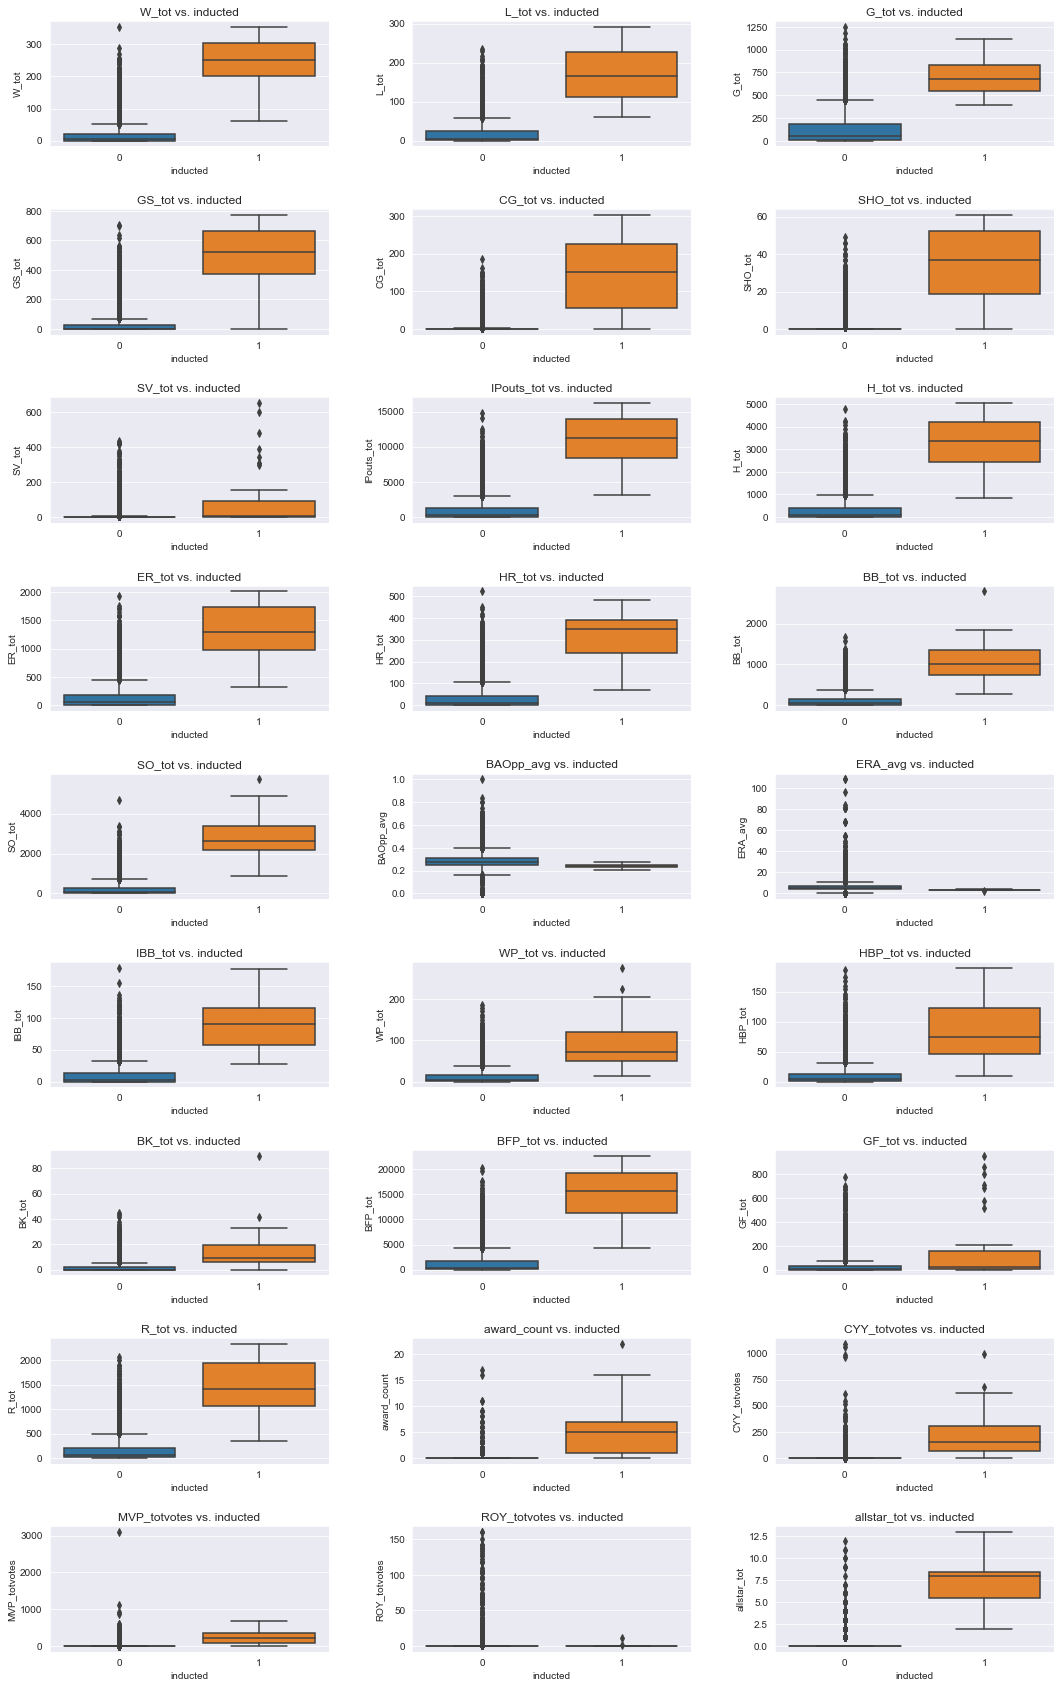

In [47]:
# Setting up box plots
sns.set_style("darkgrid")
fig, axes = plt.subplots(9, 3, figsize=(18, 30))

for i, variable in enumerate(column_names):
    # print (i)
    row = i // 3 # integer divide i by 3 (how many times does 3 go into i (discard the fraction))
                 # ex. 16 // 3 = 5 1/3 (discard the 1/3) = 5
    # print(row)
    col = i % 3 # modulo divide i by 3 times and get remainder (3 goes into )
                # ex. 16 % 3 = 16 - (3 * 5 = 15) = 1   so (row, column) is (5,1)
    # print(col)
    sns.boxplot(ax=axes[row, col], data=Pitching_Career, x='inducted', y=variable).set(title= f'{variable} vs. inducted')

plt.subplots_adjust(wspace=0.3, hspace=0.5)
# plt.show()


In [48]:
# # creating combinations for scatterplot
# column_names_scatter
# combo_list = []
# for pair in itertools.combinations(column_names_scatter, 2):
#     #print(pair)
#     combo_list.append(tuple(pair))
#     #print(combo_list)
# print(len(combo_list))

# # enumerating the combinations for scatterplot subplots
# for ele in enumerate(combo_list):
#     print (ele)

In [49]:
#combo_list[28][0] # everything is ready just set the for loops and include for the tuples and enumeration.

In [50]:
#combo_list[0][1]

In [51]:
# lists = list(split(combo_list, 6))
# lists[0]

28


378


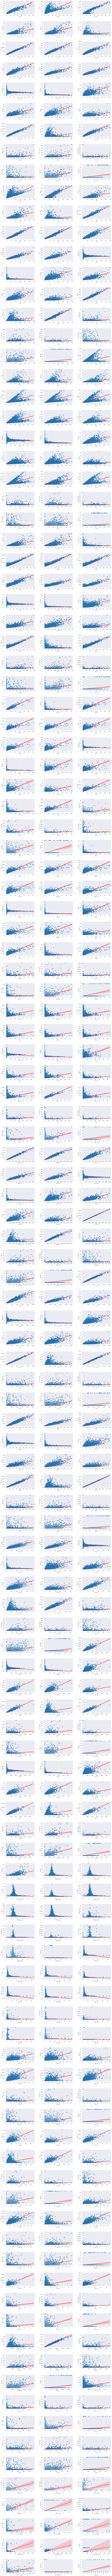

In [52]:
# setting up the scatterplot column names to be used for combinations
column_names_scatter = Pitching_Career.columns.values.tolist()
del column_names_scatter[0]
print(len(column_names_scatter))

# Plotting scatter plots for all variable combinations
sns.set_style("darkgrid")
fig, axes = plt.subplots(126, 3, figsize=(20, 500))

# creating combinations for scatterplot
column_names_scatter
combo_list = []
for pair in itertools.combinations(column_names_scatter, 2):
    #print(pair)
    combo_list.append(tuple(pair))
    #print(combo_list)
print(len(combo_list))

# dividing the combo lists into two so plots are neater.
# combo_list_split = list(split(combo_list, 2))
# combo_list1 = combo_list_split[0]
# combo_list2 = combo_list_split[1]
# combo_list3 = combo_list_split[2]
# combo_list4 = combo_list_split[3]
# combo_list5 = combo_list_split[4]
# combo_list6 = combo_list_split[5]

# enumerating the combinations for scatterplot subplots

for i, variable in enumerate(combo_list):
    # print (i)
    row = i // 3 # integer divide i by 3 (how many times does 3 go into i (discard the fraction))
                 # ex. 16 // 3 = 5 1/3 (discard the 1/3) = 5
    # print(row)
    col = i % 3 # modulo divide i by 3 times and get remainder (3 goes into )
                # ex. 16 % 3 = 16 - (3 * 5 = 15) = 1   so (row, column) is (5,1)
    # print(col)
    
    # setting up the x values
    X_value = combo_list[i][0]
    # setting up the y values
    Y_value = combo_list[i][1]
    
    # the scatter plot with regression line
    sns.regplot(x = X_value, y = Y_value, data = Pitching_Career, ax=axes[row, col], line_kws=dict(color="r"))

plt.subplots_adjust(wspace=0.3, hspace=0.5)
    

<AxesSubplot:>

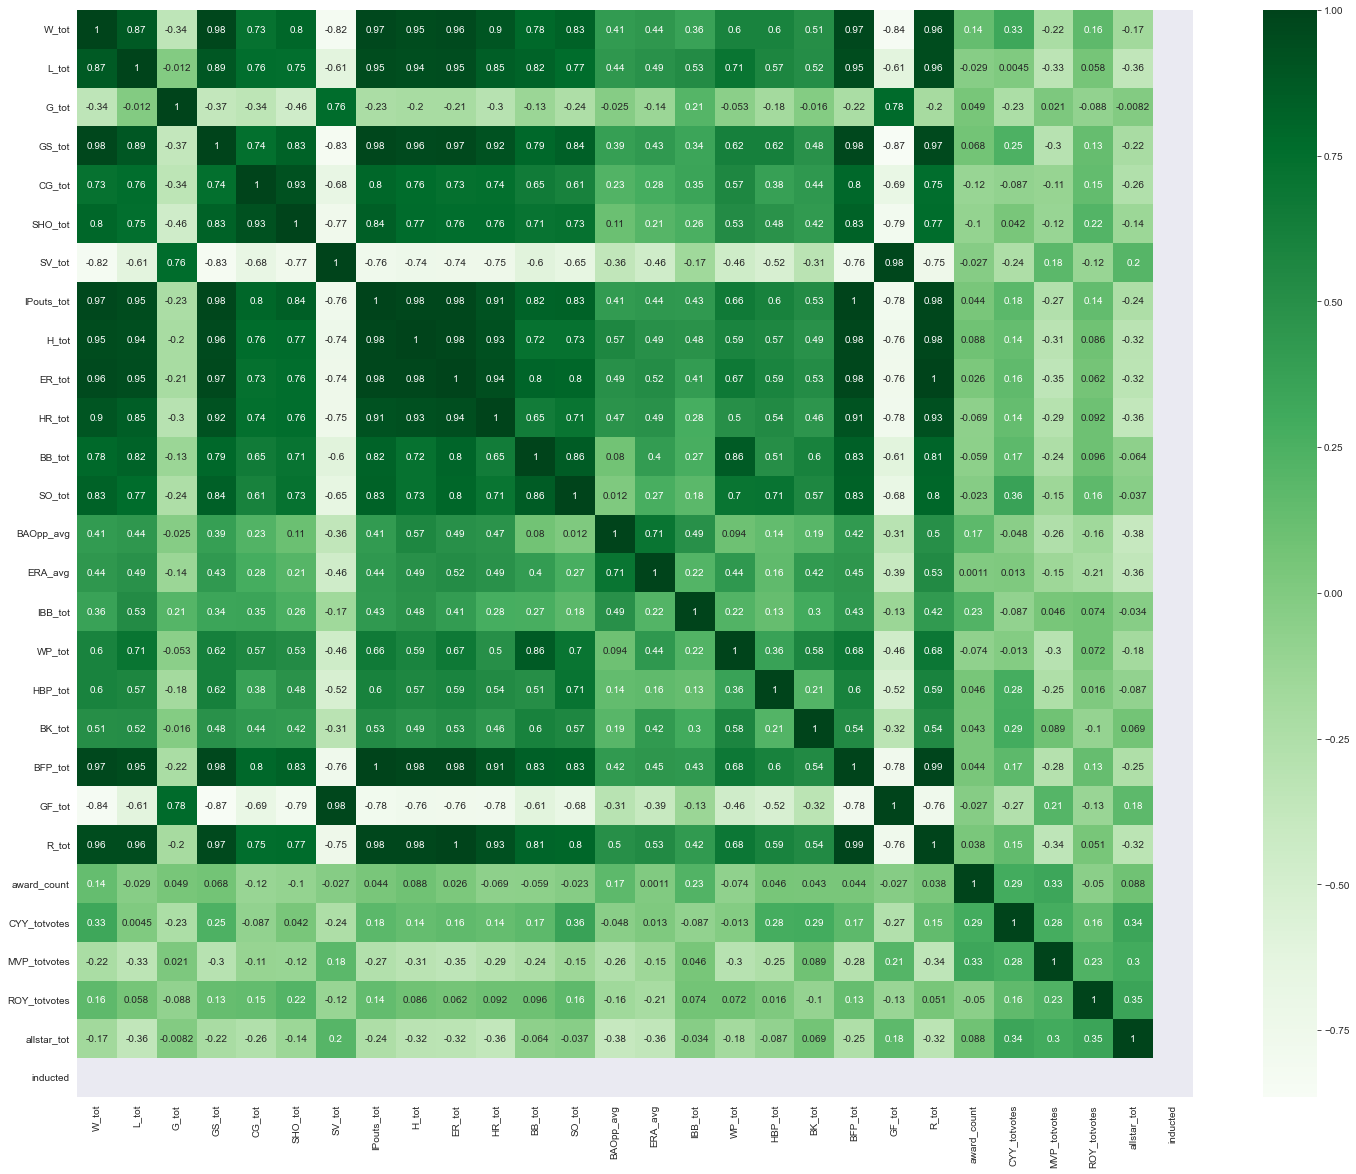

In [53]:

fig, ax = plt.subplots(figsize=(25,20)) 

matrix = Pitching_HOF_Career.corr()

#plotting correlation matrix 
sns.heatmap(matrix, cmap="Greens", annot=True)



In [54]:
np.tril([[1,2,3],[4,5,6],[7,8,9],[10,11,12]], 1) 


array([[ 1,  2,  0],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [55]:
# A good amount of variable combinations have large correlation values and show multicollinearity symptoms.
largest_10 = matrix.where(~np.tril(np.ones(
    matrix.shape, dtype=bool))).stack().nlargest(54)

print(largest_10)

IPouts_tot  BFP_tot       0.999409
ER_tot      R_tot         0.997913
BFP_tot     R_tot         0.986985
SV_tot      GF_tot        0.984274
ER_tot      BFP_tot       0.983519
H_tot       R_tot         0.983246
IPouts_tot  R_tot         0.983187
W_tot       GS_tot        0.981796
H_tot       ER_tot        0.980622
IPouts_tot  ER_tot        0.980163
H_tot       BFP_tot       0.979469
IPouts_tot  H_tot         0.978891
GS_tot      IPouts_tot    0.978212
            BFP_tot       0.977027
W_tot       IPouts_tot    0.973567
            BFP_tot       0.970962
GS_tot      ER_tot        0.968329
            R_tot         0.966489
            H_tot         0.958127
W_tot       ER_tot        0.956911
            R_tot         0.955864
L_tot       R_tot         0.955391
            BFP_tot       0.954337
W_tot       H_tot         0.953232
L_tot       IPouts_tot    0.949661
            ER_tot        0.947732
ER_tot      HR_tot        0.938753
L_tot       H_tot         0.936209
HR_tot      R_tot   

In [56]:
smallest_10 = matrix.where(~np.tril(np.ones(
    matrix.shape, dtype=bool))).stack().nsmallest(5)
print(smallest_10)

GS_tot   GF_tot   -0.865082
W_tot    GF_tot   -0.840954
GS_tot   SV_tot   -0.831647
W_tot    SV_tot   -0.822305
SHO_tot  GF_tot   -0.793292
dtype: float64


A good amount of variable combinations show symptoms of Collinearity. most of these are explainable, for example IPouts_tot (Outs Pitched (innings pitched x 3)) &  BFP_tot (Batters faced by Pitcher) go hand in hand as the amount of outs pitched is directly correlated with the amount of batters faced by the pitcher. Or another example is ER_tot (ER Earned Runs) & R_tot (Runs Allowed) go hand in hand because as the number of earned runs increases the amount of runs allowed increase as well. The same reasoning can be applied to all the other varaiable combinations as most of these are directly or semi-directly related to each other. Multicollinearity can make it difficult to understand the influence of each independent variable as the infromation is redundant and adding in extra noise.

This will be taken into consideration as I decide on variables I want to test in my regressions. the two approaches I am considering are to simply remove the redundant variables, going through all of them I wonder how many I'll have left, or take the averages of the collinear variables and run my regressions from that newly created variable maybe do both and see which model performs best. I will also be checking the Variance infation factors (VIF) to check for multicollinearity.

## Hypothesis Testing

I will start by building a logistic model that utilizes all of the columns from my data and see how it performs before making changes.

One of the challenges I will face is a severe class imbalance with my data. In my population only 0.46% of the pitchers are in the hall of fame. 

In [57]:
print('Total pitchers in dataframe:' + ' ' + str(len(Pitching_Career)))
print('Number of pitchers in Hall of Fame:' + ' ' + str(len(Pitching_Career.loc[Pitching_Career['inducted'] == 1])))
print('Number of pitchers NOT in Hall of Fame:' + ' ' + str(len(Pitching_Career.loc[Pitching_Career['inducted'] == 0])))
hof_pitchers = len(Pitching_Career.loc[Pitching_Career['inducted'] == 1])
tot_pitchers = len(Pitching_Career)
percent = round(hof_pitchers/tot_pitchers * 100, 2)
print('percent of pitchers in Hall of Fame:' + ' ' + str(percent)+ '%')

Total pitchers in dataframe: 6681
Number of pitchers in Hall of Fame: 31
Number of pitchers NOT in Hall of Fame: 6650
percent of pitchers in Hall of Fame: 0.46%


In [58]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [59]:
# splitting test and training data
# Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [60]:
# Setting up columns I want to use to make predictions
X = Pitching_Career[['W_tot',
 'L_tot',
 'G_tot',
 'GS_tot',
 'CG_tot',
 'SHO_tot',
 'SV_tot',
 'IPouts_tot',
 'H_tot',
 'ER_tot',
 'HR_tot',
 'BB_tot',
 'SO_tot',
 'BAOpp_avg',
 'ERA_avg',
 'IBB_tot',
 'WP_tot',
 'HBP_tot',
 'BK_tot',
 'BFP_tot',
 'GF_tot',
 'R_tot',
 'award_count',
 'CYY_totvotes',
 'MVP_totvotes',
 'ROY_totvotes',
 'allstar_tot',]]

# setting up my predicted value
y = Pitching_Career['inducted'] # indicator

Since my data has a huge unbalance between hall of fame ('1') and non hall of fame palyers ('0') I will be using the stratified KFold method to try to balance target variable in both training and validation test as much as possible.

In [61]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score

# choosing 5 splits because the amount of hall of fame players '1' is very limited, so using the stratified 5 Folds will make assure that around the same amount of '1' labels are present in each fold.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)

fold = 0
aucs = []
prec = []
accu = []

for train_idx, val_idx in skf.split(X, y):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    modelLogReg = LogisticRegression(solver='liblinear',max_iter=1000)
    modelLogReg.fit(X_tr, y_tr)
    pred = modelLogReg.predict(X_val)
    pred_prob = modelLogReg.predict_proba(X_val)[:, 1] # these are the probabilities of a 1 class label. This function returns an array where the first column is the probability of a 0 class label.
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)
    pre_score = precision_score(y_val, pred)

    print(f"======= Fold {fold} ========")
    cfm = confusion_matrix(y_val.tolist(), pred.tolist(), labels=[1,0])
    print(cfm)
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {pre_score:0.4f}, and AUC is {auc_score:0.4f}"
    )
    fold += 1
    aucs.append(auc_score)
    prec.append(pre_score)
    accu.append(acc_score)
oof_auc = np.mean(aucs)
prec_mean = np.mean(prec)
accu_mean = np.mean(acc_score)
print(f'Our average accuracy is {accu_mean:0.4f}, average precision is {prec_mean:0.4f}, and out of fold AUC score is {oof_auc:0.4f}')

======= Fold 0 ========
[[   3    4]
 [   3 1327]]
Our accuracy on the validation set is 0.9948, precision is 0.5000, and AUC is 0.9817
======= Fold 1 ========
[[   2    4]
 [   1 1329]]
Our accuracy on the validation set is 0.9963, precision is 0.6667, and AUC is 0.9914
======= Fold 2 ========
[[   3    3]
 [   2 1328]]
Our accuracy on the validation set is 0.9963, precision is 0.6000, and AUC is 0.8629
======= Fold 3 ========
[[   3    3]
 [   3 1327]]
Our accuracy on the validation set is 0.9955, precision is 0.5000, and AUC is 0.7872
======= Fold 4 ========
[[   5    1]
 [   3 1327]]
Our accuracy on the validation set is 0.9970, precision is 0.6250, and AUC is 0.9994
Our average accuracy is 0.9970, average precision is 0.5783, and out of fold AUC score is 0.9245


In [62]:
# Baseline
accuracy_score(y, np.zeros_like(y)), precision_score(y, np.zeros_like(y)), roc_auc_score(y, np.zeros_like(y))

c:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.9953599760514893, 0.0, 0.5)

We see in the above models with 5 fold CV that while our accuracy and AUC is relatively high, our precision is very low. in fact looking at the confusion matrices we see that the accuracy is only high because there are not a lot of positive ('1' Hall of Fame pitcher). Looking at our baseline even if one guessed the entire dataset to be negative ('0' Non-Hall of Fame pitcher) they would still get a high accuracy score but a poor AUC and precision score. This could be due to a lot of factors with the most probable one being high dimensionality: we are using 27 columns to train our model, some which as proved above are highly correlated to one another. I will use the statsmodel package to get the model summary and look at the model summary to draw findings such as p-value, etc.

### Removing Multicollinearity from dataset

In [63]:
# removing multicollinearity from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return x

In [64]:
# Removing highly Collinear columns
removed_df = remove_collinear_features(X, 0.8)

L_tot | W_tot | 0.96
GS_tot | W_tot | 0.95
GS_tot | L_tot | 0.94
SHO_tot | W_tot | 0.8
SHO_tot | CG_tot | 0.96
IPouts_tot | W_tot | 0.99
IPouts_tot | L_tot | 0.98
IPouts_tot | GS_tot | 0.95
IPouts_tot | SHO_tot | 0.8
H_tot | W_tot | 0.98
H_tot | L_tot | 0.99
H_tot | GS_tot | 0.95
H_tot | IPouts_tot | 1.0
ER_tot | W_tot | 0.97
ER_tot | L_tot | 0.99
ER_tot | GS_tot | 0.95
ER_tot | IPouts_tot | 0.99
ER_tot | H_tot | 0.99
HR_tot | W_tot | 0.95
HR_tot | L_tot | 0.96
HR_tot | GS_tot | 0.94
HR_tot | IPouts_tot | 0.96
HR_tot | H_tot | 0.97
HR_tot | ER_tot | 0.98
BB_tot | W_tot | 0.95
BB_tot | L_tot | 0.96
BB_tot | GS_tot | 0.91
BB_tot | IPouts_tot | 0.97
BB_tot | H_tot | 0.96
BB_tot | ER_tot | 0.96
BB_tot | HR_tot | 0.92
SO_tot | W_tot | 0.96
SO_tot | L_tot | 0.94
SO_tot | GS_tot | 0.91
SO_tot | IPouts_tot | 0.96
SO_tot | H_tot | 0.94
SO_tot | ER_tot | 0.94
SO_tot | HR_tot | 0.94
SO_tot | BB_tot | 0.94
IBB_tot | L_tot | 0.81
IBB_tot | G_tot | 0.82
IBB_tot | IPouts_tot | 0.8
IBB_tot | BB_tot | 

In [65]:
removed_df

W_tot  G_tot  CG_tot  SV_tot  BAOpp_avg   ERA_avg  BK_tot  award_count  \
0        16    331       0      69   0.257324  5.195312       1          0.0   
1        66    448      22      82   0.250732  3.492188       3          0.0   
2         9    406       0       2   0.260986  4.222656       2          0.0   
3         8     21       0       0   0.244019  3.869141       1          0.0   
4         1     45       0       0   0.277100  6.214844       1          0.0   
...     ...    ...     ...     ...        ...       ...     ...          ...   
6676      0      1       0       0   0.000000  0.000000       0          1.0   
6677      1     54       0       0   0.223511  5.175781       0          0.0   
6678     13    171       0       5   0.228638  3.441406       0          0.0   
6679      0      2       0       0   0.250000  4.500000       0          0.0   
6680      7     70       0       1   0.218384  2.800781       1          0.0   

      CYY_totvotes  MVP_totvotes  ROY_totvotes  allstar_tot  
0              0.0           0.0           0.0          0.0  
1              0.0           0.0           0.0          1.0  
2              0.0           0.0           0.0          0.0  
3              0.0           0.0           0.0          0.0  
4              0.0           0.0           0.0          0.0  
...            ...           ...           ...          ...  
6676           0.0          48.0           0.0          3.0  
6677           0.0           0.0           0.0          0.0  
6678           0.0           0.0           0.0          0.0  
6679           0.0           0.0           0.0          0.0  
6680           0.0           0.0           0.0          0.0  

[6681 rows x 12 columns]

In [66]:
import statsmodels.formula.api as smf

# Creating the formula string 
all_columns = ' + '.join(removed_df.columns)
formula = "inducted ~ " + all_columns 
print("Formula: ", formula, "\n")

Formula:  inducted ~ W_tot + G_tot + CG_tot + SV_tot + BAOpp_avg + ERA_avg + BK_tot + award_count + CYY_totvotes + MVP_totvotes + ROY_totvotes + allstar_tot 



In [67]:
# Putting the training predictors and responses into one DataFrame to be input into the model
trainingdata = pd.concat([X,y], axis = 1)

# Build the model
log_reg_1 = smf.logit(formula, data=trainingdata).fit()
log_reg_1.summary()

Optimization terminated successfully.
         Current function value: 0.002801
         Iterations 16


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               inducted   No. Observations:                 6681
Model:                          Logit   Df Residuals:                     6668
Method:                           MLE   Df Model:                           12
Date:                Wed, 17 Apr 2024   Pseudo R-squ.:                  0.9052
Time:                        11:59:26   Log-Likelihood:                -18.714
converged:                       True   LL-Null:                       -197.49
Covariance Type:            nonrobust   LLR p-value:                 3.566e-69
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -16.4446      5.935     -2.771      0.006     -28.077      -4.813
W_tot            0.0569      0.030      1.897      0.058      -0.002       0.116
G_tot           -0.0122      0.010     -1.276      0.202      -0.031       0.007
CG_tot           0.0238      0.013      1.824      0.068      -0.002       0.049
SV_tot           0.0386      0.019      1.978      0.048       0.000       0.077
BAOpp_avg       11.7561     20.406      0.576      0.565     -28.238      51.750
ERA_avg         -0.2063      0.362     -0.570      0.569      -0.916       0.503
BK_tot          -0.0408      0.074     -0.552      0.581      -0.186       0.104
award_count      0.3165      0.225      1.403      0.160      -0.125       0.758
CYY_totvotes    -0.0048      0.004     -1.287      0.198      -0.012       0.003
MVP_totvotes    -0.0012      0.004     -0.272      0.786      -0.010       0.007
ROY_totvotes    -0.6144      0.544     -1.129      0.259      -1.681       0.452
allstar_tot      0.9065      0.307      2.949      0.003       0.304       1.509
================================================================================

Possibly complete quasi-separation: A fraction 0.97 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [ ]:
# predict() gives a 1 or 0 
# predict_proba() gives probability

In [ ]:
# predicting non-hall of famers array of zeros against the original data. and auc for the same.
# see how model scores on hold out and just guessing all zeros. for both accuracy and auc.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
# if split too small test sample might not actually have enough test samples to predict it.
# imbalanced? use stratified kfold.
# give random state so able to compare experiments.

In [ ]:
# StratifiedKFold() wil automatically try to balance target variable in both training and validation test. important in imbalance validation set. stratified equally balance.

## Principal Component Analysis (PCA)

In [ ]:
# Prepping data for PCA
Pitching_scale = Pitching_HOF_Career.drop(columns=['playerID', 'inducted'])
#Pitching_scale.columns.values.tolist()

# Scaling all the data for PCA Transformation
scaler = StandardScaler()
scaler.fit(Pitching_scale)
scaled_data = scaler.transform(Pitching_scale)
# scaled_data

# Setting up PCA
pca = PCA()
pca.fit(scaled_data) # finding components
x_pca = pca.transform(scaled_data) # rotating and dimensionality reduction

In [ ]:
scaled_data.shape

In [ ]:
x_pca.shape

In [ ]:
pca.explained_variance_ratio_

In [ ]:
# PCA Eigenvalues
variance = pca.explained_variance_

# setting up table for Eigen Values
labels = ['PC' + str(x) for x in range(1, len(pca.explained_variance_)+1)]
d = {'Label': labels, 'Eigenvalues': variance}
eigenvalues = pd.DataFrame(d)
print(eigenvalues)

# setting up plot for Eigen Values
plt.ylabel('Eigenvalues')
plt.xlabel('# of Features')
plt.title('PCA Eigenvalues')
plt.ylim(0,max(pca.explained_variance_))
plt.axhline(y=1, color='r', linestyle='--')
plt.plot(pca.explained_variance_)

Here I have six components that have eigenvalues greater than 1 and according to Kaiser rule, drop components which eigne values are less than 1 (when data is standardized), I am keeping six components while dropping the rest

In [ ]:
# Setting up Scree Plot
plt.figure(figsize=(15,6))

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
#print(per_var)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

# setting up table for  cummulative variance
cumm_per_ver = per_var.cumsum()
d = {'label':labels, 'cummulative_variance': cumm_per_ver}
explained_var = pd.DataFrame(d)
print(explained_var)

# Setting up bar plot for the variance
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

My scree plot also agrees 85% of the variance is explained in the first six components.

In [ ]:
pca = PCA(n_components=6)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)
scaled_data.shape
x_pca.shape

In [ ]:
pca.components_

In [ ]:
df_comp = pd.DataFrame(pca.components_,columns=Pitching_scale['feature_names'])
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

In [ ]:
# test for commit 

In [ ]:
# still playing around in vscode for commit tesing

In [ ]:
Pitching_HOF_Career.iloc[0,]

In [ ]:
sns.histplot(data=Pitching_HOF_Career, x="award_count", hue="inducted", multiple="dodge")

## General information

In [ ]:
# Pitching_df and hall of fame
q = '''
with p as
    (
    SELECT 
        playerID,
        MAX(yearID) as yearID
    FROM
        Pitching_df 
    GROUP BY playerID
    )
    
SELECT 
*
FROM
    p
INNER JOIN
    HallOfFame_df h
        on p.playerID = h.playerID
WHERE
h.inducted = 'Y'
AND p.yearID >= 1955
order by 2;
'''
joined = sqldf(q, locals())
print(len(joined))
joined